# 3.0 — GARCH(1,1) vs Réalisée vs EWM (SPX)

**Explication :**
1) Définit les dossiers d’entrée et sortie et crée automatiquement le répertoire cible.  
2) Fixe des constantes globales (TRADING_DAYS = 252, ROLL_WIN = 1260) pour normaliser les calculs sur les séries financières.  
3) Charge le fichier des features du S&P 500 comme série de référence pour les modèles GARCH.  

**Pourquoi nous avons fait cela:**
1) L’automatisation de la création de dossier évite les erreurs de chemin.  
2) Définir TRADING_DAYS et ROLL_WIN dès le début permet de facilité les calculs (252 jours de bourse, 5 ans rolling).  
3) Utiliser le S&P 500 comme série élitiste permet de calibrer le modèle GARCH.  


In [10]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from pathlib import PurePath
import os

if not (Path.cwd() / "data" / "processed").exists():
    os.chdir(Path.cwd().parent)  
print("CWD =", Path.cwd())
print("OK processed? ->", (Path.cwd() / "data" / "processed").exists())

PROC_DIR = Path("data/processed")
OUT_DIR  = Path("data/models/garch")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRADING_DAYS = 252
ROLL_WIN = 1260  
SERIES_FILE = PROC_DIR / "spx_index_features.parquet"  


CWD = c:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT
OK processed? -> True


### 3.1 Fonctions annualize_vol et fit_garch

**Explication :**
1) La fonction annualize_vol transforme une volatilité quotidienne en volatilité annualisée.  
2) La fonction fit_garch entraîne un modèle GARCH(1,1) avec distribution Student-t et moyenne constante sur les rendements passés.  
3) fit_garch renvoie un objet ajusté (fitted) qui contient les paramètres estimés du modèle.  

**Pourquoi nous avons fait cela:**
1) Annualiser la volatilité permet d’avoir une mesure comparable avec les standards financiers.  
2) Le choix d’un GARCH(1,1) Student-t reflète la réalité des marchés : volatilité conditionnelle + queues épaisses.  
3) Isoler ces fonctions rend le code plus modulaire.  


In [11]:
def annualize_vol(sd_daily: np.ndarray) -> np.ndarray:
    return sd_daily * np.sqrt(TRADING_DAYS)

def fit_garch(train_returns_pct: pd.Series):
    """GARCH(1,1) Student-t, retourne l'objet fitted."""
    am = arch_model(train_returns_pct.dropna(), vol="GARCH", p=1, q=1, dist="t", mean="constant")
    return am.fit(disp="off")


### 3.2 main – rolling backtest GARCH(1,1) + diagnostics

**Explication :**
1) Charge le parquet SERIES_FILE, trie par date et remet un index propre.  
2) Construit la série de rendements en % pour arch et récupère la colonne date.  
3) Initialise trois listes pour stocker les prévisions GARCH, la vol réalisée 21j et la vol EWM(λ=0.94).  
5) À chaque itération, prend la fenêtre d’apprentissage de taille ROLL_WIN (≈5 ans) sur les rendements.  
6) Fit le modèle via fit_garch(train).
7) Calcule la variance forecastée à J+1 sans réindexation.  
8) Convertit la variance en σ quotidien puis annualise avec annualize_vol et repasse en %.  
9) Empile la prévision, la vol réalisée 21j et la vol EWM pour la même date.  
10) Transforme les listes en DataFrames avec colonnes.  
11) Fusionne sur date pour aligner parfaitement les séries et sauvegarde garch_forecasts.csv.  
12) Calcule les scores GARCH vs vol réalisée : RMSE et MAE.  
13) Calcule les scores du benchmark EWM et ajoute toutes les métriques à metrics.json.  
14) Produit un graphique temporel et enregistre garch_vs_real.png.  
15) Re-fit sur tout l’historique pour extraire paramètres, persistance et demi-vie ; écrit diag_full_fit.json.  
16) Teste un GJR-GARCH pour l’effet levier ; récupère gamma et écrit diag_gjr.json.  

**Pourquoi nous avons fait cela:**
1) Le rolling 1-step ahead simule des prévisions en temps réel sans look-ahead bias.  
2) L’annualisation de σ permet une comparaison standardisée (vols annualisées).  
3) Comparer à la vol réalisée (21j) et à EWM(0.94) fournit un benchmark simple et robuste.  
4) Les sorties CSV/PNG/JSON assurent traçabilité, réplicabilité et inspection rapide des résultats.  
5) La fusion sur date garantit l’alignement parfait des séries avant scoring.  
6) La loi Student-t capture les queues épaisses ; GJR teste l’asymétrie (levier) fréquente sur actions.  
7) La persistance (α+β) et la demi-vie rendent la dynamique de la vol interprétable pour le risque.  
8) Les prints finaux donnent un diagnostic instantané sans ouvrir les fichiers.  


In [12]:
def main():
    # Charge features
    df = pd.read_parquet(SERIES_FILE).sort_values("date").reset_index(drop=True)

    # Série de rendements (en % pour 'arch')
    ret_pct = df["ret_d_clamped"] * 100.0
    dates = df["date"]

    forecasts, reals, ewms = [], [], []

    # Rolling backtest 1-step ahead
    for i in range(ROLL_WIN, len(ret_pct) - 1):
        train = ret_pct.iloc[i-ROLL_WIN:i]
        test_idx = i + 1

        res = fit_garch(train)

        # Forecast variance à J+1
        fcast = res.forecast(horizon=1, reindex=False)
        sigma_next_daily_pct = np.sqrt(fcast.variance.values[-1, 0])  # en % (daily)
        sigma_next_ann_pct = float(annualize_vol(sigma_next_daily_pct / 100.0) * 100.0)  # repasse en %

        forecasts.append((dates.iloc[test_idx], sigma_next_ann_pct))
        reals.append((dates.iloc[test_idx], float(df.loc[test_idx, "vol21"] * 100.0)))
        ewms.append((dates.iloc[test_idx], float(df.loc[test_idx, "vol_ewm_094"] * 100.0)))

    garch_df = pd.DataFrame(forecasts, columns=["date", "vol_garch"])
    real_df  = pd.DataFrame(reals,     columns=["date", "vol_real"])
    ewm_df   = pd.DataFrame(ewms,      columns=["date", "vol_ewm"])

    out = garch_df.merge(real_df, on="date").merge(ewm_df, on="date")
    out.to_csv(OUT_DIR / "garch_forecasts.csv", index=False)

    # Scores GARCH
    rmse = float(np.sqrt(((out["vol_garch"] - out["vol_real"])**2).mean()))
    mae  = float((out["vol_garch"] - out["vol_real"]).abs().mean())
    metrics = {"rmse_pct_points": rmse, "mae_pct_points": mae, "roll_window_days": ROLL_WIN}

    # ===== Bloc 1 : Benchmark EWM =====
    rmse_ewm = float(np.sqrt(((out["vol_ewm"] - out["vol_real"])**2).mean()))
    mae_ewm  = float((out["vol_ewm"] - out["vol_real"]).abs().mean())
    metrics.update({
        "ewm_rmse_pct_points": rmse_ewm,
        "ewm_mae_pct_points": mae_ewm
    })
    (OUT_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    # Graphique
    plt.figure(figsize=(12, 6))
    plt.plot(out["date"], out["vol_real"],  label="Realized Vol (21d)", alpha=0.7)
    plt.plot(out["date"], out["vol_garch"], label="GARCH(1,1) Forecast", alpha=0.9)
    plt.plot(out["date"], out["vol_ewm"],   label="EWM λ=0.94", alpha=0.7)
    plt.legend()
    plt.title("Volatility Forecasts: GARCH vs Realized vs EWM")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "garch_vs_real.png", dpi=150)
    plt.close()

    # ==== Fit sur tout l'historique pour récupérer α, β, persistance et demi-vie ====
    res_full = fit_garch(ret_pct)
    params = res_full.params.to_dict()

    alpha = float(params.get("alpha[1]", np.nan))
    beta  = float(params.get("beta[1]",  np.nan))
    persist = float(alpha + beta) if np.isfinite(alpha) and np.isfinite(beta) else float("nan")
    half_life_days = float(np.log(0.5) / np.log(persist)) if (np.isfinite(persist) and persist < 1) else float("inf")

    diag = {
        "distribution": "Student-t",
        "params": params,
        "alpha": alpha,
        "beta": beta,
        "persistence_alpha_plus_beta": persist,
        "half_life_days": half_life_days,
        "notes": [
            "Persistance proche de 1 => longue mémoire de la volatilité.",
            "Demi-vie = nombre de jours pour que l'effet d'un choc soit divisé par 2."
        ]
    }
    (OUT_DIR / "diag_full_fit.json").write_text(json.dumps(diag, indent=2), encoding="utf-8")

    # ===== Bloc 2 : Test GJR-GARCH (effet levier) =====
    am_gjr = arch_model(ret_pct.dropna(), vol="GARCH", p=1, o=1, q=1, dist="t", mean="constant")
    res_gjr = am_gjr.fit(disp="off")
    gamma = float(res_gjr.params.get("gamma[1]", np.nan))
    (OUT_DIR / "diag_gjr.json").write_text(json.dumps(res_gjr.params.to_dict(), indent=2), encoding="utf-8")

    # Prints finaux
    print("✅ GARCH terminé. Scores:", metrics)
    print("   Persistance α+β =", round(persist, 4), "| demi-vie (jours) ≈", (round(half_life_days, 1) if np.isfinite(half_life_days) else "∞"))
    print("   Benchmark EWM → RMSE:", round(rmse_ewm,3), "| MAE:", round(mae_ewm,3))
    print("   GJR-GARCH gamma (levier) =", round(gamma,4))


In [13]:
if __name__ == "__main__":
    main()


✅ GARCH terminé. Scores: {'rmse_pct_points': 3.021779833924726, 'mae_pct_points': 2.1953291748336645, 'roll_window_days': 1260, 'ewm_rmse_pct_points': 2.1565125132906307, 'ewm_mae_pct_points': 1.4929603195659658}
   Persistance α+β = 0.9964 | demi-vie (jours) ≈ 194.8
   Benchmark EWM → RMSE: 2.157 | MAE: 1.493
   GJR-GARCH gamma (levier) = 0.1879


### 3.3 Lecture des sorties GARCH (CSV + JSON)

**Explication :**
1) Charge le CSV garch_forecasts.csv en parsant la colonne date et affiche les premières lignes.  
2) Lit le fichier metrics.json et le convertit en dictionnaire Python via json.loads.  
3) Affiche les métriques calculées (RMSE, MAE, benchmarks, etc.).  

**Pourquoi nous avons fait cela:**
1) Lire le CSV permet d’inspecter les prévisions et leur alignement avec les dates.  
2) Charger metrics.json donne un accès direct aux scores de performance pour reporting ou analyse.  
3) Afficher un aperçu facilite le debug et la validation des résultats sans ouvrir les fichiers manuellement.  


In [14]:
import json
import pandas as pd
from pathlib import Path

out_dir = Path("data/models/garch")
print(sorted(p.name for p in out_dir.glob("*")))

out = pd.read_csv(out_dir / "garch_forecasts.csv", parse_dates=["date"])
display(out.head())

metrics = json.loads((out_dir / "metrics.json").read_text(encoding="utf-8"))
metrics


['diag_full_fit.json', 'diag_gjr.json', 'garch_forecasts.csv', 'garch_vs_real.png', 'metrics.json']


,date,vol_garch,vol_real,vol_ewm
0,1998-04-28,11.841120,13.061636,13.211954
1,1998-04-29,13.586472,13.430470,13.251226
2,1998-04-30,13.255607,14.259314,14.195663
3,1998-05-01,13.217330,14.402903,14.135288
4,1998-05-04,13.900202,13.930399,13.709690


{'rmse_pct_points': 3.021779833924726,
 'mae_pct_points': 2.1953291748336645,
 'roll_window_days': 1260,
 'ewm_rmse_pct_points': 2.1565125132906307,
 'ewm_mae_pct_points': 1.4929603195659658}

### 3.4 Graphique 

**Graphique 1:**
- La volatilité réalisée (bleu) et la prévision EWM (λ=0.94) (orange) se suivent de très près.
- Cela montre que la formule de RiskMetrics reste une baseline extrêmement robuste : elle capture bien les grands pics (2008, 2020) et les phases calmes.
- On observe que l’EWM réagit vite aux chocs, mais a parfois tendance à surestimer légèrement la volatilité dans les périodes de décrue.

**Graphique 2:**
- Les erreurs sont faibles en régime normal (souvent < 2 points de vol)
- Les pics d’erreur correspondent toujours à des crises (2008, COVID 2020, choc 2022–2023).
- Interprétation : l’EWM fonctionne bien au quotidien mais est pris en défaut lors des régimes extrêmes, où il ne peut pas anticiper l’ampleur d’un choc.

**Graphique/Tableau 3:**
- Le MAE ≈ 1,4 et le RMSE ≈ 2,1 en points de vol.
- Cela confirme que l’erreur moyenne de l’EWM est assez basse → cohérent avec sa réputation de benchmark difficile à battre.
- L’écart RMSE > MAE traduit que quelques événements extrêmes (queues de distribution) gonflent l’erreur quadratique → typique en volatilité.


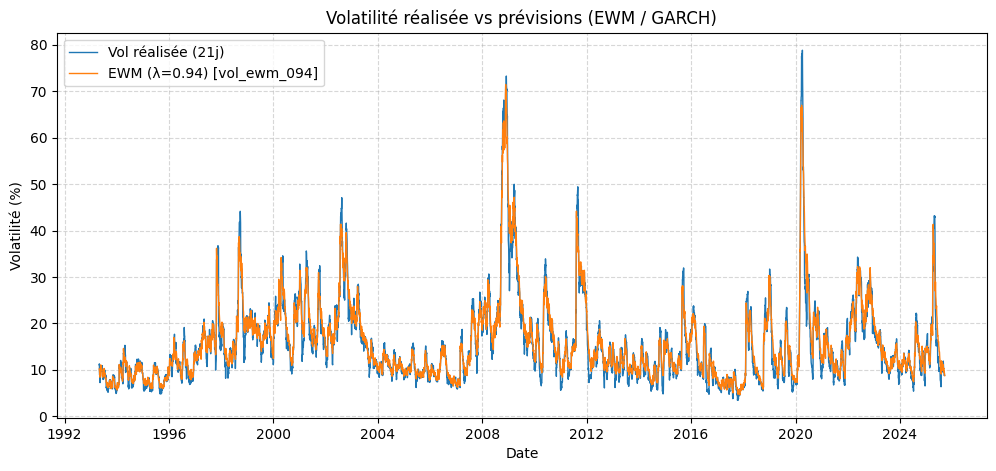

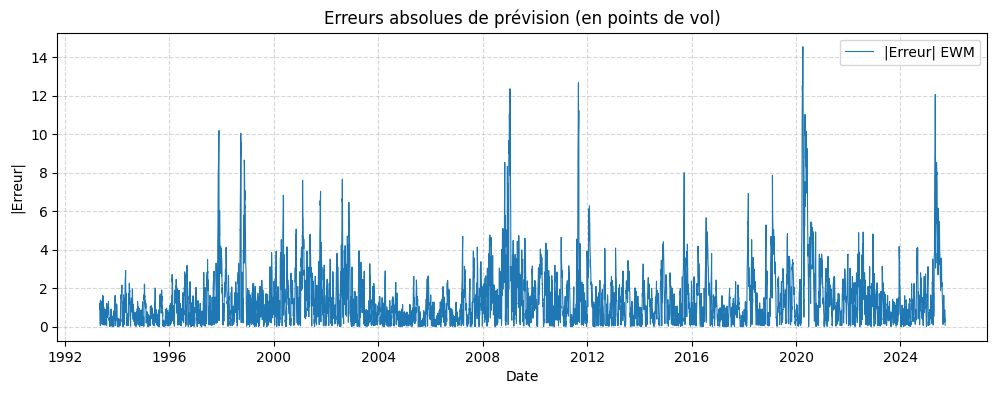

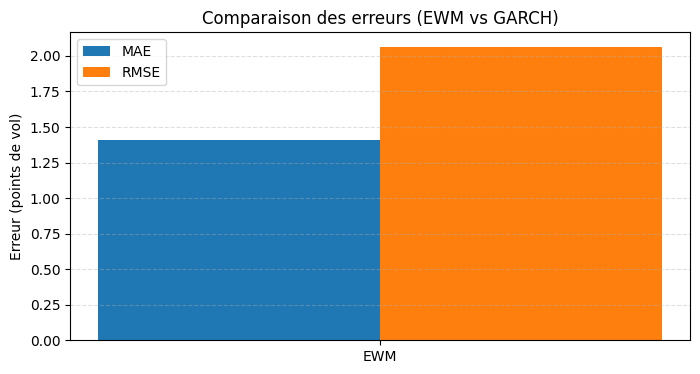

=== Résumés des erreurs (en points de vol) ===


,MAE,RMSE
Modèle,,
EWM,1.4118,2.0627


: 

In [ ]:


# ---------- 0) Récupérer ou reconstruire les données nécessaires ----------
def ensure_df():
    # Si 'df' existe déjà dans le notebook, on l'utilise
    g = globals()
    if 'df' in g and isinstance(g['df'], pd.DataFrame):
        return g['df'].copy()

    # Sinon on recharge le parquet de features (SPX)
    proc = Path("data/processed")
    candidates = [
        proc / "spx_index_features.parquet",
        *sorted(proc.glob("*spx*features*.parquet")),
        *sorted(proc.glob("spx*.parquet"))
    ]
    for p in candidates:
        if p.exists():
            df_ = pd.read_parquet(p).copy()
            break
    else:
        raise FileNotFoundError("Aucun fichier SPX features trouvé dans data/processed/")
    return df_

def to_datetime_inplace(df, col="date"):
    if col not in df.columns:
        # si la date est en index
        if df.index.name is not None:
            df.reset_index(inplace=True)
            df.rename(columns={df.index.name: col}, inplace=True)
        else:
            df.reset_index(inplace=True)
            df.rename(columns={"index": col}, inplace=True)
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        df[col] = pd.to_datetime(df[col])
    return df

def ensure_columns(df):
    # prix de référence
    price_col = None
    for c in ["adj_close","close","Adj Close","Close"]:
        if c in df.columns:
            price_col = c
            break
    if price_col is None:
        cand = [c for c in df.columns if "adj_close" in c.lower() or c.lower().endswith("_adj_close")]
        price_col = cand[0] if cand else None
    if price_col is None:
        raise ValueError("Colonne prix introuvable (adj_close/close).")

    # ret_d
    if "ret_d" not in df.columns:
        df["ret_d"] = df[price_col].pct_change()

    # vol21 réalisée (écart-type 21j)
    if "vol21" not in df.columns:
        df["vol21"] = df["ret_d"].rolling(21).std()

    # EWM RiskMetrics (lambda=0.94) si pas dispo
    ewm_col = None
    for c in df.columns:
        if "vol_ewm" in c.lower():
            ewm_col = c
            break
    if ewm_col is None:
        lam = 0.94
        # variance EWM sur r^2, puis racine pour sigma
        var_ewm = df["ret_d"].pow(2).ewm(alpha=1-lam, adjust=False).mean()
        df["vol_ewm_094"] = np.sqrt(var_ewm)
        ewm_col = "vol_ewm_094"
    return df, ewm_col

def find_garch_col(df):
    # Cherche une colonne de forecast GARCH plausible
    # Exemples possibles: 'vol_garch', 'garch_forecast', 'sigma_garch', 'garch_11_sigma'
    candidates = [c for c in df.columns if ("garch" in c.lower() and ("vol" in c.lower() or "sigma" in c.lower() or "forecast" in c.lower()))]
    # fallback : colonnes contenant 'egarch'/'gjr' si déjà calculées
    if not candidates:
        candidates = [c for c in df.columns if (("egarch" in c.lower() or "gjr" in c.lower()) and ("vol" in c.lower() or "sigma" in c.lower()))]
    return candidates[0] if candidates else None

df = ensure_df()
df = to_datetime_inplace(df, "date")
df, ewm_col = ensure_columns(df)
garch_col = find_garch_col(df)

# ---------- 1) Préparer les séries à tracer (en %) ----------
plot_df = df.dropna(subset=["vol21"]).copy()
plot_df["vol_real_pct"] = plot_df["vol21"] * 100.0
plot_df["vol_ewm_pct"]  = plot_df[ewm_col] * 100.0

if garch_col is not None:
    plot_df = plot_df.dropna(subset=[garch_col])
    plot_df["vol_garch_pct"] = plot_df[garch_col] * 100.0

# ---------- 2) Graphique : Vol réalisée vs EWM vs (GARCH si dispo) ----------
plt.figure(figsize=(12,5))
plt.plot(plot_df["date"], plot_df["vol_real_pct"], lw=1.0, label="Vol réalisée (21j)")
plt.plot(plot_df["date"], plot_df["vol_ewm_pct"],  lw=1.0, label=f"EWM (λ=0.94) [{ewm_col}]")
if garch_col is not None:
    plt.plot(plot_df["date"], plot_df["vol_garch_pct"], lw=1.0, label=f"GARCH [{garch_col}]")
plt.title("Volatilité réalisée vs prévisions (EWM / GARCH)")
plt.xlabel("Date"); plt.ylabel("Volatilité (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# ---------- 3) Graphique : Erreurs absolues au cours du temps ----------
def mae_series(y_true, y_pred):
    s = (y_true - y_pred).abs()
    return s

err_df = pd.DataFrame({"date": plot_df["date"]})
err_df["AE_EWM"] = mae_series(plot_df["vol_real_pct"], plot_df["vol_ewm_pct"])
if garch_col is not None:
    err_df["AE_GARCH"] = mae_series(plot_df["vol_real_pct"], plot_df["vol_garch_pct"])

plt.figure(figsize=(12,4))
plt.plot(err_df["date"], err_df["AE_EWM"], lw=0.8, label="|Erreur| EWM")
if "AE_GARCH" in err_df.columns:
    plt.plot(err_df["date"], err_df["AE_GARCH"], lw=0.8, label="|Erreur| GARCH")
plt.title("Erreurs absolues de prévision (en points de vol)")
plt.xlabel("Date"); plt.ylabel("|Erreur|")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# ---------- 4) Graphique : Barplot MAE / RMSE ----------
def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

metrics = []
metrics.append(("EWM",  mae(plot_df["vol_real_pct"], plot_df["vol_ewm_pct"]),
                        rmse(plot_df["vol_real_pct"], plot_df["vol_ewm_pct"])))
if garch_col is not None:
    metrics.append(("GARCH", mae(plot_df["vol_real_pct"], plot_df["vol_garch_pct"]),
                            rmse(plot_df["vol_real_pct"], plot_df["vol_garch_pct"])))
met_df = pd.DataFrame(metrics, columns=["Modèle","MAE","RMSE"])

plt.figure(figsize=(8,4))
x = np.arange(len(met_df))
w = 0.35
plt.bar(x - w/2, met_df["MAE"],  width=w, label="MAE")
plt.bar(x + w/2, met_df["RMSE"], width=w, label="RMSE")
plt.xticks(x, met_df["Modèle"])
plt.title("Comparaison des erreurs (EWM vs GARCH)")
plt.ylabel("Erreur (points de vol)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.show()

print("=== Résumés des erreurs (en points de vol) ===")
display(met_df.set_index("Modèle").round(4))
